数据样例:
          fs        ops  filesz  blksz  numjobs  bandwidth(MiB/s)
0  ext4-dax      write   32768   4096        1               628
1  ext4-dax       read   32768   4096        1              1488
2  ext4-dax  randwrite   32768   4096        1               467
3  ext4-dax   randread   32768   4096        1              1354
4  ext4-dax  overwrite   32768   4096        1              2218


/tmp/ipykernel_616635/15007215.py:33: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("./performance-comparison-table-store", delim_whitespace=True)


AttributeError: 'Rectangle' object has no attribute 'set_hatch_color'

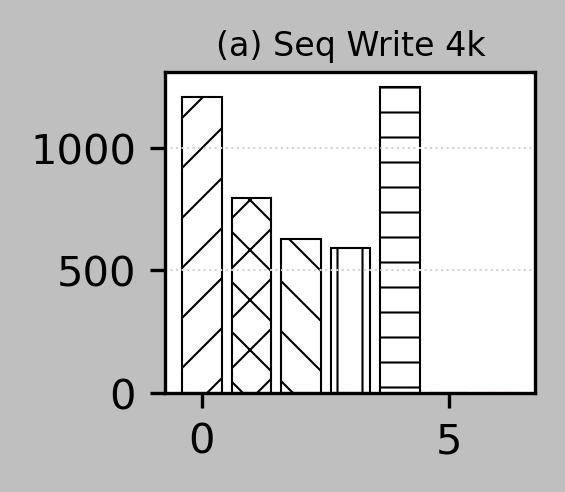

In [ ]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54

# matplotlib style settings
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None


with open("./performance-comparison-table-store", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

fig = plt.figure(dpi=300, figsize=(cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(6)))

line_width = 0.5
marks = [">", "x", "s", "D", "^", "v", "8", "o"]
line_patterns = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"]
fss = df['fs'].drop_duplicates().reset_index().drop(columns=['index'])['fs']
num_jobs = [1, 2, 4, 8, 16, 28, 32]
x = list(num_jobs)
df['bandwidth'] = df['bandwidth(MiB/s)'] / 1024

mapping = {
    "nova": "NOVA",
    "pmfs": "PMFS",
    "ext4-dax": "EXT4-DAX",
    "ext4-raid": "EXT4-RAID",
    "winefs": "WineFS",
    "odinfs-12": "OdinFS",
    "parfs-12": "ChimeraFS",
    "idel": "Ideal-FS"
}
mapped_fss = [mapping.get(item, item) for item in fss]

subplot_config = [
    # Upper row
    {'row': 0, 'col': 0, 'op': 'write', 'blksz': 4096, 'title_label': 'a', 'y_lims': [0, 14]},
    {'row': 0, 'col': 1, 'op': 'write', 'blksz': 8192, 'title_label': 'b', 'y_lims': [0, 14]},
    {'row': 0, 'col': 2, 'op': 'write', 'blksz': 16384, 'title_label': 'c', 'y_lims': [0, 14]},
    {'row': 0, 'col': 3, 'op': 'write', 'blksz': 32768, 'title_label': 'd', 'y_lims': [0, 14]},
    {'row': 0, 'col': 4, 'op': 'read', 'blksz': 4096, 'title_label': 'e', 'y_lims': [0, 35]},
    {'row': 0, 'col': 5, 'op': 'read', 'blksz': 32768, 'title_label': 'f', 'y_lims': [0, 35]},
    # Lower row
    {'row': 1, 'col': 0, 'op': 'randwrite', 'blksz': 4096, 'title_label': 'g', 'y_lims': [0, 14]},
    {'row': 1, 'col': 1, 'op': 'randwrite', 'blksz': 8192, 'title_label': 'h', 'y_lims': [0, 14]},
    {'row': 1, 'col': 2, 'op': 'randwrite', 'blksz': 16384, 'title_label': 'i', 'y_lims': [0, 14]},
    {'row': 1, 'col': 3, 'op': 'randwrite', 'blksz': 32768, 'title_label': 'j', 'y_lims': [0, 14]},
    {'row': 1, 'col': 4, 'op': 'randread', 'blksz': 4096, 'title_label': 'k', 'y_lims': [0, 35]},
    {'row': 1, 'col': 5, 'op': 'randread', 'blksz': 32768, 'title_label': 'l', 'y_lims': [0, 35]},
]

op_type_map = {
    'write': 'Seq Write',
    'randwrite': 'Rnd Write',
    'read': 'Seq Read',
    'randread': 'Rnd Read'
}

blksz_str_map = {
    4096: '4k',
    8192: '8k',
    16384: '16k',
    32768: '32k'
}

lines = []
for i, config in enumerate(subplot_config):
    plt.subplot(2, 6, i+1)
    op = config['op']
    blksz = config['blksz']
    
    op_type = op_type_map[op]
    blksz_str = blksz_str_map[blksz]
    plt.title(f"({config['title_label']}) {op_type} {blksz_str}", fontsize=8)
    
    for fs_idx, fs in enumerate(fss):
        data = df[(df['fs'] == fs) & (df['ops'] == op) & (df['blksz'] == blksz)]
        y = data['bandwidth'].iloc[:len(num_jobs)]
        
        if len(x) != len(y):
            print(f"Data mismatch: {fs} {op} {blksz}")
            continue
        
        markercolor = "red" if fs == "parfs-12" else "white"
        markeredgecolor = "red" if fs == "parfs-12" else "black"
        color = "red" if fs == "parfs-12" else "black"
        if i == 0:  # Only add labels to first subplot
            p, = plt.plot(x, y, color=color, marker=marks[fs_idx],
                          markerfacecolor=markercolor, markeredgecolor=markeredgecolor,
                          markersize=3, markeredgewidth=0.5,
                          linewidth=line_width, label=mapped_fss[fs_idx], linestyle=line_patterns[fs_idx])
            lines.append(p)
        else:
            plt.plot(x, y, color=color, marker=marks[fs_idx],
                     markerfacecolor=markercolor, markeredgecolor=markeredgecolor,
                     markersize=3, markeredgewidth=0.5,
                     linewidth=line_width, label='_nolegend_', linestyle=line_patterns[fs_idx])

    # Axis labels
    if config['col'] == 0:
        plt.ylabel('Tput (GiB/s)', fontsize=8)
    if config['row'] == 1:
        plt.xlabel('Threads (#.)', fontsize=8)
    
    # Formatting
    plt.xticks([1, 8, 16, 24, 32], labels=[1, 8, 16, 24, 32], fontsize=8)
    plt.ylim(config['y_lims'])
    plt.yticks(fontsize=8)
    
    ax = plt.gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
    # plt.tick_params(left=True, bottom=True, right=False, top=False, which='major', width=0.5, length=3)

fig.legend(lines, mapped_fss, loc='upper center', 
          bbox_to_anchor=(0.5, 1.1), ncol=8,
          columnspacing=0.5, handletextpad=0.5, 
          handlelength=1.5, frameon=False, fontsize=8,)

# plt.subplots_adjust(left=0.06, right=0.98, top=0.88, bottom=0.08,
#                    hspace=0.3, wspace=0.25)
plt.tight_layout(pad=0.4)
plt.savefig("./FIO-MT.pdf", bbox_inches='tight', pad_inches=0)

/tmp/ipykernel_663983/2141316716.py:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')


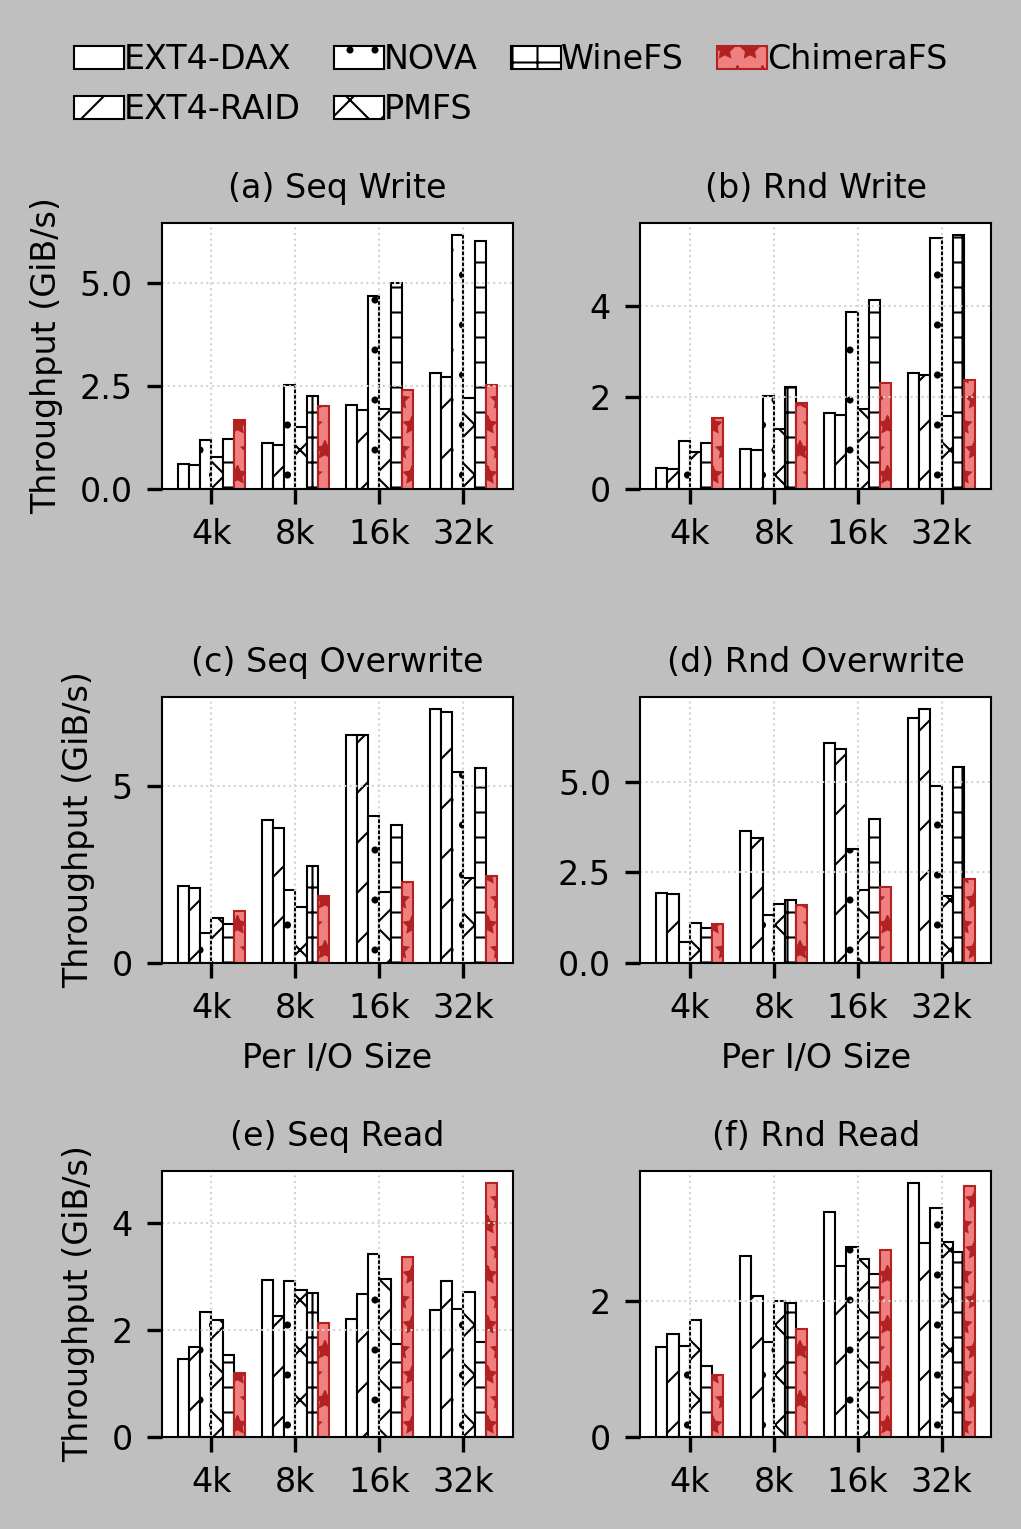

In [9]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54

# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

with open("./performance-comparison-table-store", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

# Filter data for numjobs=1
df = df[df['numjobs'] == 1]

fig = plt.figure(dpi=300, figsize=(cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(12)))

fss = df['fs'].drop_duplicates().reset_index().drop(columns=['index'])['fs']
df['bandwidth'] = df['bandwidth(MiB/s)'] / 1024  # Convert to GiB/s

mapping = {
    "nova": "NOVA",
    "pmfs": "PMFS",
    "ext4-dax": "EXT4-DAX",
    "ext4-raid": "EXT4-RAID",
    "winefs": "WineFS",
    "odinfs-12": "OdinFS",
    "parfs-12": "ChimeraFS",
    "idel": "Ideal-FS"
}
mapped_fss = [mapping.get(fs, fs) for fs in fss]

# subplot_config = [
#     {'row': 0, 'col': 0, 'op': 'write', 'title_label': 'a', 'y_lims': [0, 10]},
#     {'row': 0, 'col': 1, 'op': 'randwrite', 'title_label': 'b', 'y_lims': [0, 10]},
#     {'row': 1, 'col': 0, 'op': 'overwrite', 'title_label': 'c', 'y_lims': [0, 10]},
#     {'row': 1, 'col': 1, 'op': 'randoverwrite', 'title_label': 'd', 'y_lims': [0, 10]},
#     {'row': 2, 'col': 0, 'op': 'read', 'title_label': 'e', 'y_lims': [0, 10]},
#     {'row': 2, 'col': 1, 'op': 'randread', 'title_label': 'f', 'y_lims': [0, 10]},
# ]

subplot_config = [
    {'row': 0, 'col': 0, 'op': 'write', 'title_label': 'a'},
    {'row': 0, 'col': 1, 'op': 'randwrite', 'title_label': 'b'},
    {'row': 1, 'col': 0, 'op': 'overwrite', 'title_label': 'c'},
    {'row': 1, 'col': 1, 'op': 'randoverwrite', 'title_label': 'd'},
    {'row': 2, 'col': 0, 'op': 'read', 'title_label': 'e'},
    {'row': 2, 'col': 1, 'op': 'randread', 'title_label': 'f'},
]

op_type_map = {
    'write': 'Seq Write',
    'read': 'Seq Read',
    'randwrite': 'Rnd Write',
    'randread': 'Rnd Read',
    'overwrite': 'Seq Overwrite',
    'randoverwrite': 'Rnd Overwrite'
}

blksz_str_map = {
    4096: '4k',
    8192: '8k',
    16384: '16k',
    32768: '32k'
}

hatches = ['', '//', '..', 'xx', '++', '**', 'oo', '||']
colors = ['white' if fs != 'parfs-12' else 'lightcoral' for fs in fss]
edge_colors = ['black' if fs != 'parfs-12' else 'firebrick' for fs in fss]

lines = []
for i, config in enumerate(subplot_config):
    plt.subplot(3, 2, i+1)
    op = config['op']
    data_subset = df[df['ops'] == op]
    blksz_list = sorted(data_subset['blksz'].unique())
    
    x = np.arange(len(blksz_list))
    n_fs = len(fss)
    width = 0.8 / n_fs  # Adjust width based on number of file systems
    
    for fs_idx, fs in enumerate(fss):
        y = []
        for blksz in blksz_list:
            filtered = data_subset[(data_subset['fs'] == fs) & (data_subset['blksz'] == blksz)]
            y.append(filtered['bandwidth'].iloc[0] if not filtered.empty else 0)
        x_pos = x + fs_idx * width
        bars = plt.bar(x_pos, y, width=width, 
                       edgecolor=edge_colors[fs_idx], 
                       color=colors[fs_idx],
                       hatch=hatches[fs_idx],
                       linewidth=0.5,
                       label=mapped_fss[fs_idx] if i == 0 else '_nolegend_')
        if i == 0:
            lines.append(bars[0])
    
    plt.title(f"({config['title_label']}) {op_type_map[op]}", fontsize=8)
    plt.xticks(x + (n_fs-1)*width/2, [blksz_str_map[b] for b in blksz_list], fontsize=8)
    # plt.ylim(config['y_lims'])
    plt.yticks(fontsize=8)
    
    if config['row'] == 1:
        plt.xlabel('Per I/O Size', fontsize=8)
    if config['col'] == 0:
        plt.ylabel('Throughput (GiB/s)', fontsize=8)
    
    ax = plt.gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)

fig.legend(lines, mapped_fss, loc='upper center', 
          bbox_to_anchor=(0.5, 1.08), ncol=4,
          columnspacing=1, handletextpad=0, 
          handlelength=1.5, frameon=False, fontsize=8)

plt.tight_layout()
plt.savefig("./FIO-BS.pdf", bbox_inches='tight', pad_inches=0.05)